# Explore the Data

This notebook just runs a few tests and displays a few plots to highlights trends in our nfl/cfb/combine data

In [1]:
import Exploratory_Data_Functions
import importlib
importlib.reload(Exploratory_Data_Functions)
from Exploratory_Data_Functions import *

In [3]:
tdc = pd.read_csv('data_sets/wr_tdc_clean.csv')

### How complete is our data?

In [8]:
pd.crosstab(tdc['cfb method'], tdc['combine method'])

combine method,fail after search (missing link),fail after search (missing table),success from merge
cfb method,,,
fail (eg link broken),8,14,31
success,10,30,300


- success from main, main1, main2, or main3: nfl data is good
- fail (eg link broken): no nfl data
- fail after main1: player never had 'Receiving & Rushing' stats (he was used for something else)

In [4]:
pd.crosstab(tdc['nfl method'], tdc['nfl table type'].fillna('NaN'))

nfl table type,Defense & Fumbles Table,Games Table,Kick & Punt Returns Table,NaN,Receiving & Rushing Table,Rushing & Receiving Table
nfl method,,,,,,
fail (eg link broken),0,0,0,49,0,0
fail after main1,10,0,10,0,0,0
success from main,0,13,0,0,256,0
success from main1,0,0,0,0,50,0
success from main2,0,0,0,0,0,2
success from main3,0,0,0,0,0,3


# 1) Investigating the data

We're looking to find how the cfb and combine stats impact the nfl stats, in particular the **longevity of a player in the nfl**. But how do we define such metric? Can it simply be the number of seasons or the number of games/yards?

In this part, we start by investigating our current data and search for trends in the NFL numbers. To recall, we have two sets of NFL stats:
- basic data, coming from the draft table
- more complete nfl data, coming from each player's nfl table

One important thing to remember is that a lot of our data is made of floats, but some are not such as nfl or college teams, cfb conferences and cfb class upon draft entry 

## A - Basic approach

Let's start with basic statistical inferences, such as the number of games, yards and number of seasons in the league

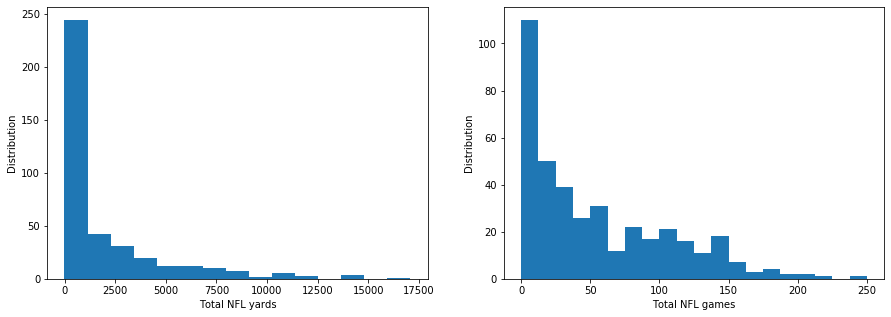

In [23]:
_ = plt.subplots(2,1,figsize=(15,5))

plt.subplot(1, 2, 1)
_ = plt.hist(tdc['rec yards'], bins = 15)
_ = plt.xlabel('Total NFL yards')
_ = plt.ylabel('Distribution')

plt.subplot(1, 2, 2)
_ = plt.hist(tdc['games'], bins = 20)
_ = plt.xlabel('Total NFL games')
_ = plt.ylabel('Distribution')

Pretty similar distributions. A lot of players have 0 to no games/yards

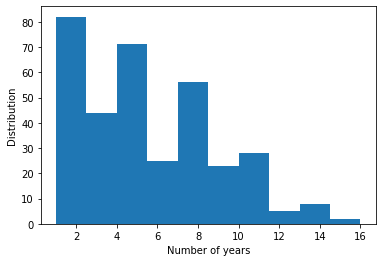

In [7]:
_ = plt.hist(tdc['last year'] - tdc['entry year'] + 1)
_ = plt.xlabel('Number of years')
_ = plt.ylabel('Distribution')

Let's now see how the mean of these stats is affected by some the college class and the conference:

In [8]:
print('The mean of total games played and total yards is:',tdc['games'].mean(), tdc['rec yards'].mean())

display(tdc.groupby(['cfb conference'])[['games','rec yards']].agg(['count','mean']).sort_values(by = ('games','mean'), ascending = False))

display(tdc.groupby(['cfb class'])[['games','rec yards']].agg(['count','mean']).sort_values(by = ('games','mean'), ascending = False))


The mean of total games played and total yards is: 53.99491094147583 1892.9338422391857


games            rec yards             
               count       mean     count         mean
cfb conference                                        
Big East          25  78.440000        25  3489.080000
Ind                8  67.125000         8  2164.375000
CUSA              19  67.052632        19  2639.315789
ACC               40  66.325000        40  2527.875000
SEC               59  60.254237        59  2213.338983
Big Ten           45  60.177778        45  1969.977778
MAC               17  57.588235        17  2287.000000
Pac-10            44  52.113636        44  1488.409091
WAC               21  41.857143        21  1133.904762
MWC               17  41.764706        17  1389.588235
Big 12            43  41.674419        43  1403.697674
Sun Belt           4  16.750000         4   236.750000

games             rec yards             
          count        mean     count         mean
cfb class                                         
SO            8  123.625000         8  5996.125000
JR           56   77.553571        56  3470.428571
SR          244   50.754098       244  1600.622951
FR            1    0.000000         1     0.000000

We notice that the conference has an impact on the mean observed for total games and receiving yards. Watch as the volume for those is quite different.

The NFL won't allow FR or SO to enter the draft anymore, but what we observe is that the Juniors entering the draft have better numbers than their Senior counterparts

Finally, let's do a scatterplot with some of the cfb columns

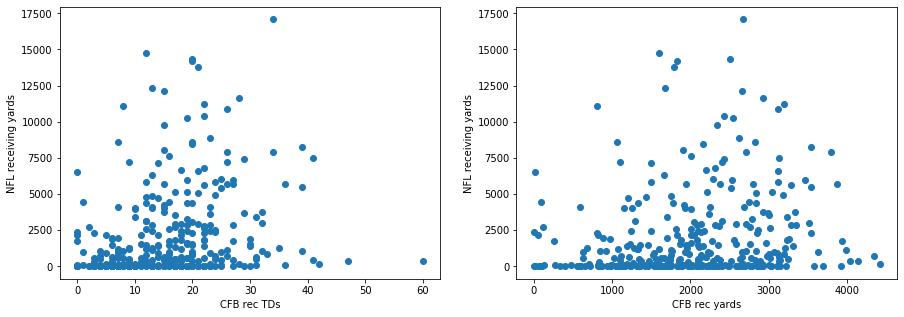

In [9]:
plt.subplots(1,2, figsize=(15,5))

plt.subplot(1,2,1)
_ = plt.scatter(tdc['cfb rec td'], tdc['rec yards'])
_ = plt.xlabel('CFB rec TDs')
_ = plt.ylabel('NFL receiving yards')

plt.subplot(1,2,2)
_ = plt.scatter(tdc['cfb rec yards'], tdc['rec yards'])
_ = plt.xlabel('CFB rec yards')
_ = plt.ylabel('NFL receiving yards')

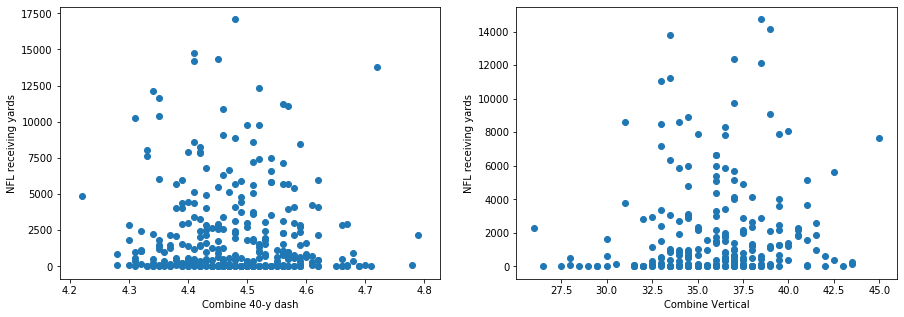

In [24]:
plt.subplots(1,2, figsize=(15,5))

plt.subplot(1,2,1)
_ = plt.scatter(tdc['combine forty'], tdc['rec yards'])
_ = plt.xlabel('Combine 40-y dash')
_ = plt.ylabel('NFL receiving yards')

plt.subplot(1,2,2)
_ = plt.scatter(tdc['combine vertical'], tdc['rec yards'])
_ = plt.xlabel('Combine Vertical')
_ = plt.ylabel('NFL receiving yards')

## B - Correlation of floats columns

For the columns of floats, let's compute the correlation matrix between the nfl stats and the cfb and combine numbers

In [10]:
columns_floats = list(range(13,21)) +list(range(26,53)) +list(range(60,73)) +list(range(75,83)) + [85]
tdc_floats = tdc.iloc[:,columns_floats]
tdcf = tdc_floats.corr(method='pearson')

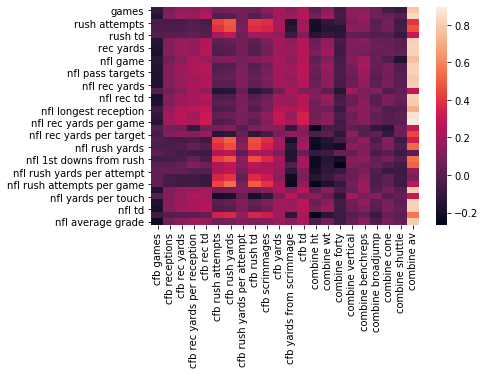

In [11]:
_ = sns.heatmap(tdcf.loc['games':'nfl average grade'
                         ,'cfb games':], annot=False)

There are clearly useless rows/columns that we'll get rid of in a minute

# 2) Let's collect more data: number of yards per season. 
We need to access the nfl table again, using the 'nfl method' and 'nfl table type'. We access the nfl url and do some quick scrapping to obtain the number of yards per season  

- success from main and Receiving & Rushing Table: use nfl url, capture first table
- success from main and others: nothing (players with little game, no other stats)
- success from main1: use nfl url, capture table with 'Receiving & Rushing Table'
- success from main2/3: use nfl url, capture table 'Rushing & Receiving Table', invert,
- fail after main1: nothing (player never used for receiving but has other stats)
- fail (eg link broken): nothing

If we have a nfl table, we store the data from the column 'yards' per season into a list of floats. Otherwise, we just return [0]

In [16]:
pd.crosstab(tdc['nfl method'], tdc['nfl table type'].fillna('NaN'))

nfl table type,Defense & Fumbles Table,Games Table,Kick & Punt Returns Table,NaN,Receiving & Rushing Table,Rushing & Receiving Table
nfl method,,,,,,
fail (eg link broken),0,0,0,49,0,0
fail after main1,10,0,10,0,0,0
success from main,0,13,0,0,256,0
success from main1,0,0,0,0,50,0
success from main2,0,0,0,0,0,2
success from main3,0,0,0,0,0,3


### Trying out the code with all 7 cases
### Generating the number of yards per season for each player

In [157]:
#ind_try = [0, 23, 16, 30, 73, 24]
url = tdc.loc[ind_try[0],'nfl url']

soup = BeautifulSoup(urlopen(url),'html.parser')
table_0_soup = soup.find_all('table')[0]
table_nfl = nflstats(table_0_soup)
# table_list = generate_all_nfl_tables(url)
# table_0_soup = find_nfl_table(table_list, 'Rushing & Receiving Table')
# table_nfl = nflstats(table_0_soup)
# table_nfl = switch_rushing_receiving(table_nfl)

r = table_nfl.loc[0:overall_nfl_index(table_nfl)-1,'rec yards']
pd.to_numeric(table_nfl.loc[0:overall_nfl_index(table_nfl)-1,'rec yards'], errors='coerce').fillna(0.0)

#rlist = main(tdc, 'yards')
#rdf = pd.DataFrame(rlist)
#rdf.to_csv('data_sets/nyps_df.csv',index=False)

# 3) Generating new metrics:

We define our new metrics as 
- #of seasons with yards > threshold
- #of rec yards during the first five seasons

The later is better since it would include complete data for players being drafted even in 2011

In [12]:
rdf = pd.read_csv('data_sets/nyps_df.csv')

In [13]:
thresh_yards = 200
thresh_years = 5
for i in rdf.index.values:
    tdc.loc[i, 'seasons above thresh'] = np.sum(rdf.loc[i] > thresh_yards)
    
for i, row in rdf.iterrows():
    tdc.loc[i, 'yards first 5 seasons'] = np.sum(row[0:5])

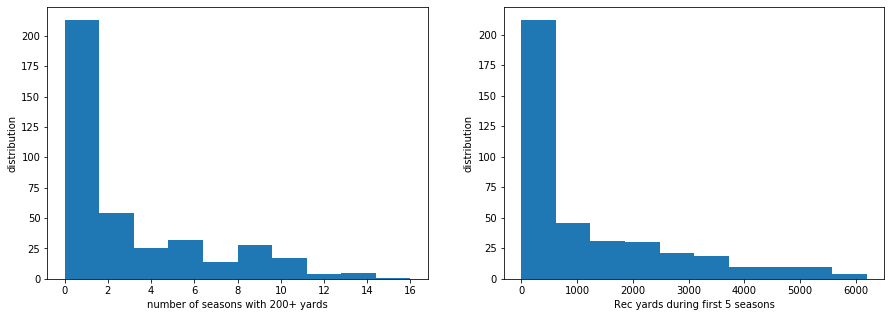

In [14]:
plt.subplots(1, 2, figsize = (15,5))

plt.subplot(1,2,1)
_ = plt.hist(tdc['seasons above thresh'])
_ = plt.xlabel('number of seasons with 200+ yards')
_ = plt.ylabel('distribution')

plt.subplot(1,2,2)
_ = plt.hist(tdc['yards first 5 seasons'])
_ = plt.xlabel('Rec yards during first 5 seasons')
_ = plt.ylabel('distribution')

Let's add those to our correlation matrix

In [15]:
columns_floats = list(range(13,21)) +list(range(26,53)) +list(range(60,73)) +list(range(75,83)) + [92,93]
tdc_floats = tdc.iloc[:,columns_floats]
tdcf = tdc_floats.corr(method='pearson')

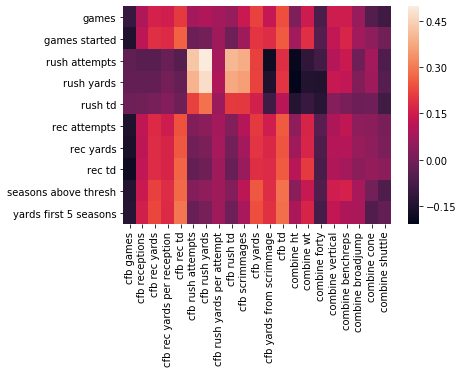

In [16]:
_ = sns.heatmap(tdcf.loc[['games','games started','rush attempts', 'rush yards', 'rush td',
                          'rec attempts', 'rec yards', 'rec td','seasons above thresh','yards first 5 seasons']
                          ,'cfb games':'combine shuttle'], annot=False)

# 4) Exploring more of the proper data

From our earlier plots, let's narrow our correlation matrix to a set of rows and a set of columns that have a larger number of positive correlations. For now, let's ignore:
- the nfl rush stats,
- the cfb rush stats,
- the 'combine average' (which seems to be a poorly defined metric not given to all players)

In [17]:
columns_floats = list(range(13,21)) +list(range(26,53)) +list(range(60,73)) +list(range(75,83)) + [85,92,93]
tdc_floats = tdc.iloc[:,columns_floats]
tdcf = tdc_floats.corr(method='pearson')

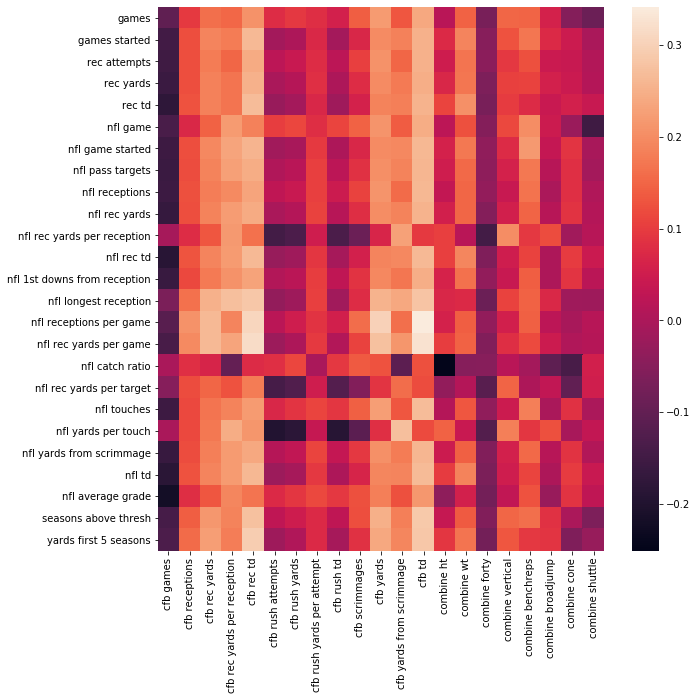

In [18]:
_ = plt.figure(figsize = (10,10))

_ = sns.heatmap(tdcf.loc[['games','games started','rec attempts','rec yards','rec td',
                          'nfl game', 'nfl game started','nfl pass targets', 'nfl receptions',
                          'nfl rec yards','nfl rec yards per reception', 'nfl rec td',
                          'nfl 1st downs from reception', 'nfl longest reception','nfl receptions per game',
                          'nfl rec yards per game', 'nfl catch ratio','nfl rec yards per target', 
                          'nfl touches', 'nfl yards per touch', 'nfl yards from scrimmage', 'nfl td',
                          'nfl average grade','seasons above thresh','yards first 5 seasons']
                          ,'cfb games':'combine shuttle'], annot=False)

In [19]:
tdc['cfb conference'] = tdc['cfb conference'].fillna('Other')
tdc['cfb class'] = tdc['cfb class'].fillna('Non Declared')

tdc.to_csv('data_sets/wr_tdc_new.csv',index = False)

In [25]:
tdc = pd.read_csv('data_sets/wr_tdc_new.csv')

# 5) Some observations ...

It is clear that a few sets of cfb stats have an enormous impact on how well the player performs in the nfl; the combine numbers (on average) seem to matter a little less. Some of the categories, which do not correlate well with the nfl numbers (to our surprise) are:
- the number of college football games
- the combine 40yard dash

Additionally, from earlier heatmaps, it appears that **rushing stats either from the nfl or cfb** don't correlate too well with the rest of the data, as we would expect for receivers in the league.

# 6) ... and some questions

### The metric
Now: we still have to find the **nfl metric**, one that will correlate well with the chosen cfb/combine data. I would suggest (for now) that our list of choices for this metric is:
- games (or 'nfl game' they're the same),
- rec yards (or 'nfl rec yards' - same),
- rec td (or 'nfl rec td' - same),
- nfl receptions per game,
- nfl rec yards per game,
- nfl td or
- season above thresh

What will it be?

### Non-floats data

Additionally, these correlation plots do not include non-floats data. Therefore, how can we thoroughly study the impact of the player's cfb conference or its class status upon entry in the draft? In fact, we thought that players coming from power 5 conferences (SEC, ACC, Big10, Big12 and PAC12) would have more games or more touchdowns on average than the others. But in fact, those conferences are more represented in volume, rather than performances. So how will we account for those differences in our model?